# Inverse Kinematics

Author: Michael Greer

This notebook discusses collision avoidance using nullspace motion.

Notebook is based on [this paper](http://robotics.caltech.edu/~jwb/courses/ME115/handouts/MaciejewskiKleinRedundantObstacleAvoidance.pdf).

### Null Space

As discussed in a prior notebook, the null space can be used to reconfigure a manipulator without generating any end effector velocity. We can use null space motion to satisfy a task-space target while avoiding collision between the arm and obstacles in the space.

In this notebook, the obstacles are modelled as circles in the 2-D plane. Any shape of obstacles could be used, as long as the closest point on both the obstacle and the manipulator can be computed.

In this notebook, the closest point on the manipulator to a circle is calculated, and the associated distance vector is used to move that closest point away from the obstacle.

In [4]:
import numpy as np
from numpy import cos, sin, pi

from scipy.linalg import null_space

import matplotlib.pyplot as plt

import sympy as sp

### Visual

We reuse the plotting system from the previous notebooks, adding ways to plot circular obstacles in the space.

In [5]:
def plot_robot(links, joints, circles, plot_distances=False):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    total_len = sum(links)
    
    xs, ys = robot_lines(links, joints)
    
    fig, ax = plt.subplots()

    ax.set_aspect( 1 )
    ax.set_xlim((-1 * total_len, total_len))
    ax.set_ylim((-1 * total_len, total_len))

    fig.set_figheight(10)
    fig.set_figwidth(10)
    
    plt.plot(xs, ys)
    
    for c in circles:
        
        circle = plt.Circle(c.center, c.radius, color='r', fill=False)
        ax.add_artist(circle)
        
        if (plot_distances):
            
            mindist = 1e15
            
            minpoints = []
            
            for i in range(1, len(xs)):
                
                p1, p2 = c.closest_points(np.array([xs[i-1], ys[i-1]]), np.array([xs[i], ys[i]]))
                
                dist = np.linalg.norm(p1 - p2)
                
                if (dist < mindist):
                    
                    mindist = dist
                    minpoints = [p1, p2]
                    
            plt.plot([minpoints[0][0], minpoints[1][0]], [minpoints[0][1], minpoints[1][1]], color='r')
    
    plt.title('Robot Manipulator Pose')
    
    return

# Returns a list of all of the points defining the joints of the robot on the plane
def robot_lines(links, joints):
    
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
        
    if (isinstance(links, np.ndarray)):
        links = links.flatten().tolist()
    
    xs = [0]
    ys = [0]
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        xs.append(xs[-1] + l * cos(total_q))
        ys.append(ys[-1] + l * sin(total_q))
        
    return xs, ys
        
        

### Obstacles
We need a way to represent circles and find the vectors from arm links to the boundary of the circle.

In [6]:
class Circle:
    
    radius = 0
    center = 0
    
    def __init__(self, center, radius):
        
        self.center = center
        self.radius = radius
        
        return
    
    
    # Returns the points on the line segment and circle that are closest together
    # Line segment runs between l1 and l2
    def closest_points(self, l1, l2):
                
        # find closest distance between line and center of the circle
        length_squared = (l2 - l1) @ (l2 - l1)
        
        t = max(0, min(1, (self.center - l1) @ (l2 - l1) / length_squared))
        
        line_point = l1 + t * (l2 - l1)
        
        distance = np.linalg.norm(line_point - self.center)
        
        circle_point = self.center + (line_point - self.center) * (self.radius / distance)
        
        return (line_point, circle_point)
        

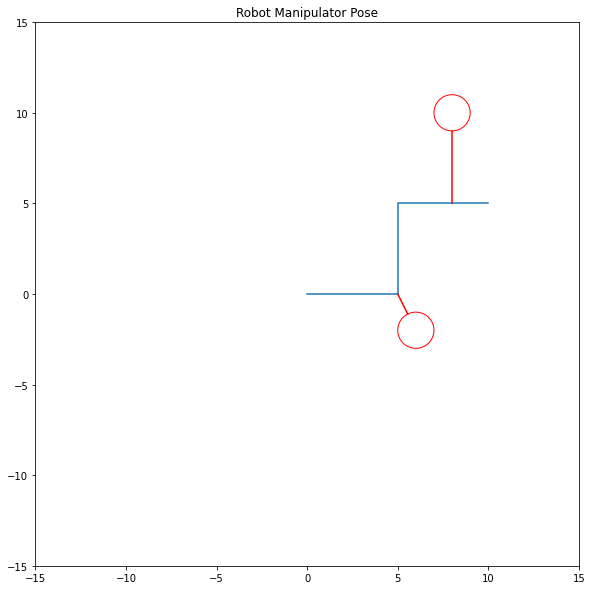

In [7]:
obs = []
obs.append(Circle(np.array([8, 10]), 1))
obs.append(Circle(np.array([6, -2]), 1))

plot_robot([5, 5, 5], [0, pi/2, -pi/2], obs, plot_distances = True)

### Forward Kinematics and Jacobian

We use the same functions for these as previous solutions

In [8]:
def f_kine(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    x = 0
    y = 0
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        x += l * cos(total_q)
        y += l * sin(total_q)
        
    return np.array([[x],[y]])



def jacobian(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
            
    # Form symbolic q matrix
    
    qs = []
    
    for i in range(0,len(joints)):
        
        qs.append(sp.Symbol('q{}'.format(i)))
        
        
    jac = np.zeros((2, len(links)))
    
    x = 0
    y = 0
    
    # Form forward kinematics
    for i in range(len(links)):
                   
        total_q = 0
        
        for j in range(i + 1):
            
            total_q += qs[j]
            
        x += links[i] * sp.cos(total_q)
        y += links[i] * sp.sin(total_q)
        
    
    # Differentiate to find jacobian      
    for i in range(len(links)):
        
        Jx = sp.diff(x, qs[i])
        Jy = sp.diff(y, qs[i])
        
        for k in range(len(links)):
            
            Jx = Jx.subs(qs[k], joints[k])
            Jy = Jy.subs(qs[k], joints[k])
                
        jac[0,i] = Jx.evalf()
        jac[1,i] = Jy.evalf()
            
    return jac

### Jacobian of a Certain Point

When a Jacobian is typically discussed, it relates the joint velocity to the end effector velocity. However, a Jacobian can be calculated to relate the joint velocity to any arbitrary point on the manipulator. For collision avoidance, we need to be able to get the Jacobian of the closest point to an obstacle with respect to the joints. To accomplish this, we construct a "sub-manipulator" that contains only the links up to the point specified. We then pass this manipulator to the original Jacobian function.

In [106]:
def jacobian_point(links, joints, point):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    newlinks = []
    newjoints = []
    
    xs, ys = robot_lines(links, joints)
    
    pointfound = False
    
    for i in range(1, len(xs)):
        
        l1 = np.array([xs[i-1], ys[i-1]])
        l2 = np.array([xs[i], ys[i]])
        
        length_squared = (l2 - l1) @ (l2 - l1)
        
        t = max(0, min(1, (point - l1) @ (l2 - l1) / length_squared))
        
        line_point = l1 + t * (l2 - l1)
                        
        if (np.linalg.norm(line_point - point) < 0.0001):
            
            #print(line_point, point)
            
            newlinks.append(links[i-1] * t)
            newjoints.append(joints[i-1])
            pointfound = True
            break
            
        else:
            
            newlinks.append(links[i-1])
            newjoints.append(joints[i-1])
            
    
    if (not pointfound): return 0
            
    jac = jacobian(newlinks, newjoints)
    
    full_jac = np.zeros((2, len(joints)))
    
    full_jac[:,0:jac.shape[1]] = jac
    
    #print(newlinks, newjoints)
    #print(full_jac)
        
    return full_jac

### Inverse Kinematics
For the inverse kinematics we not only want to satisfy the target constraint, but also avoid hitting targets with the arm itself. To do this, we find the closest points of the arm to each obstacle, then move the arm in the nullspace to keep that closest point from hitting the obstacle.

Note that large movements of the arm could cause intersection with an obstacle that was not the closest at the time of evaluation for that step, so we limit the maximum move towards the target.

In [332]:
# Note: this ONLY works for targets within the workspace. For points outside the workspace this function will not exit
def i_kine_obs(links, joints, target, obstacles, error_trace=False):
    
    current_q = joints
    
    # This term limits the maximum delta x per move
    max_move = 0.1
    
    e_trace = []
    
    count = 0
    
    while(1):
        
        count += 1
        
        # Get the current end effector position
        current_x = f_kine(links, current_q)
        
        # Get the vector to the target
        delta_x = target - current_x
        
        # Find the magnitude of the movement required
        delta_x_norm = np.linalg.norm(delta_x)
        
        e_trace.append(delta_x_norm)
        
        # Limit the maximum magnitude of delta_x
        if (delta_x_norm > max_move):
            
            delta_x /= (delta_x_norm / max_move)
            
        # Stop if the end effector is sufficently close to target
        if (delta_x_norm < 0.001):
            
            break
                  
                
                
        # Find the obstacle avoidance data
        
        xs, ys = robot_lines(links, joints)
                
        minpointscircles = []
        mindistcircles = 1e15
        
        # Check the distance to each of the circles and save the closest points
        for c in obstacles:
                            
            mindist = 1e15
            
            minpoints = []
            
            for i in range(1, len(xs)):
                
                p1, p2 = c.closest_points(np.array([xs[i-1], ys[i-1]]), np.array([xs[i], ys[i]]))
                
                dist = np.linalg.norm(p1 - p2)
                
                if (dist < mindist):
                    
                    mindist = dist
                    minpoints = [p1, p2]
        
            if (mindist < mindistcircles):
                
                mindistcircles = mindist
                minpointscircles = minpoints
        
        
        # Find the Jacobian of a certain point along the manipulator
        jac_obs = jacobian_point(links, joints, minpointscircles[0])
                
        avoid_vec = minpointscircles[0] - minpointscircles[1]
        
        avoid_norm = np.linalg.norm(avoid_vec)
                
        # Avoidance vector needs to be of unit length
        avoid_vec = avoid_vec/(avoid_norm)
        
        avoid_vec = avoid_vec.reshape((-1,1))
        
        
        
        # Find the required movements in the joint space
        
        # Gain is based on distance from the nearest obstacle
        # Scales up as distance gets closer
        alpha = 1
        beta = 1 / (mindistcircles)
                        
        jac = jacobian(links, current_q)
        
        jac_pinv = np.linalg.pinv(jac)
        
        jac_obs_pinv = np.linalg.pinv(jac_obs)
        
        # Formula found in relevant paper
        A = jac_pinv @ delta_x
        
        B = np.linalg.pinv(jac_obs @ (np.eye(len(joints)) - jac_pinv @ jac))
        
        C = beta * avoid_vec - jac_obs @ jac_pinv @ delta_x
                
        # If the B matrix is singular, the pseudoinverse will be huge. We will check for this and not use it
        if (np.linalg.norm(B) > 1e10): alpha = 0
        
        
        # Equation from relevant paper
        delta_q = A + alpha * B @ C
                            
        # Add the change to find the updated joint angles
        current_q += delta_q
        
        if (count > 500): 
            
            print("Maximum iteration reached")
            break
            
        
    return (current_q, e_trace) if error_trace else current_q

Text(0.5, 1.0, 'Error Trace')

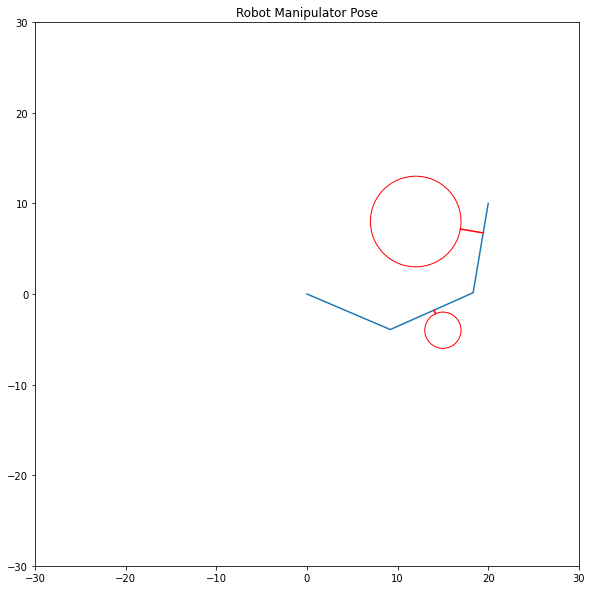

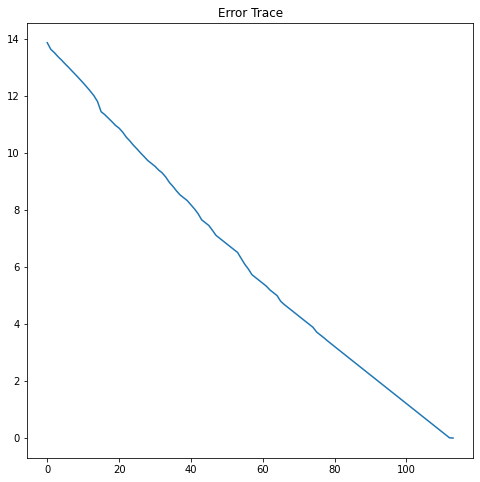

In [333]:
links = [10.0, 10.0, 10.0]
joints = np.array([[0.2],[-0.4],[0.2]])
target = np.array([[20.0],[10.0]])
obs = [Circle(np.array([12, 8]), 5), Circle(np.array([15, -4]), 2)]

#plot_robot(links, joints, obs, plot_distances = True)

joints, e_trace = i_kine_obs(links, joints, target, obs, error_trace=True)

plot_robot(links, joints, obs, plot_distances = True)

plt.figure(figsize=(8,8))
plt.plot(e_trace)
plt.title('Error Trace')